In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
Belgium = pd.read_hdf("Temp/BEL_TEMP_GEFS.h5")

In [3]:
Belgium2022 = Belgium[Belgium['ForecastDateTime'] > pd.to_datetime("2021-12-31")]

In [4]:
Belgium2022['TimeDelta_h'] = (Belgium2022['ValueDateTime'] - Belgium2022['ForecastDateTime']).astype('timedelta64[h]').astype(int)

<ipython-input-4-6e59954645df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Belgium2022['TimeDelta_h'] = (Belgium2022['ValueDateTime'] - Belgium2022['ForecastDateTime']).astype('timedelta64[h]').astype(int)


In [5]:
Belgium2022['TimeDelta_d'] = Belgium2022['TimeDelta_h']/24

<ipython-input-5-05e80ee63d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Belgium2022['TimeDelta_d'] = Belgium2022['TimeDelta_h']/24


In [6]:
Belgium2022 = Belgium2022.iloc[-50000:] # Just look at the last 50k rows

In [7]:
interested_in = 10 # Which forecast horizon are you interested in? (in days)

std_devs = []

for date in tqdm(Belgium2022.ForecastDateTime, position = 0, leave = True):

    df_date = Belgium2022[Belgium2022.ForecastDateTime == date]
    df_date_10d = df_date[df_date['TimeDelta'] == 24*interested_in]
    df_date_10d_redshift = df_date_10d[df_date_10d['source'] == "Redshift"]
    standard_deviation = df_date_10d_redshift['value'].std()
    std_devs.append(standard_deviation)

  0%|          | 0/50000 [00:00<?, ?it/s]


KeyError: 'TimeDelta'

<ipython-input-8-d7d3b9392131>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ax.plot(pd.Series(std_devs).rolling(120).mean())


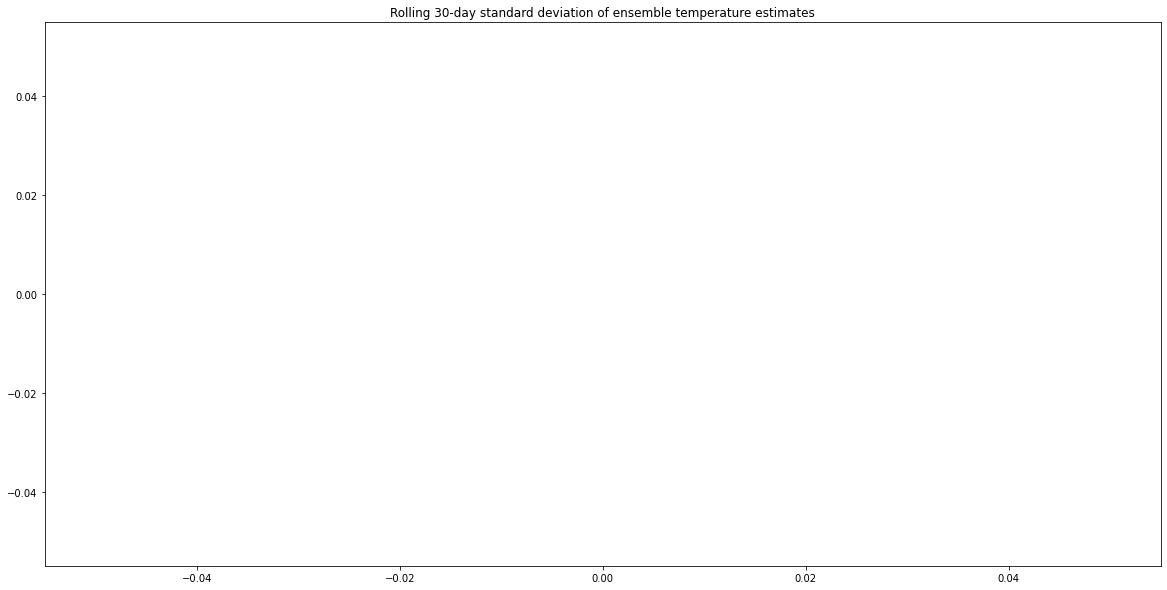

In [8]:
fig, ax = plt.subplots()
ax.plot(pd.Series(std_devs).rolling(120).mean())
ax.set_title("Rolling 30-day standard deviation of ensemble temperature estimates")
fig.set_size_inches(20, 10)

In [9]:
horizons = Belgium2022.TimeDelta_d.unique()

In [10]:
def find_forecast_std_by_horizon(forecast_date, horizons):

    Belgium2022_selected = Belgium2022[Belgium2022.ForecastDateTime == forecast_date ]
    std_over_horizons = []
    
    for horizon in horizons:
        indv_ensembles = Belgium2022_selected[Belgium2022_selected['TimeDelta_d'] == horizon]
        std_over_horizons.append(indv_ensembles['value'].std())
    
    return pd.DataFrame(std_over_horizons, index = horizons)

In [11]:
overall_df = pd.DataFrame(index = horizons)

In [ ]:
for day in tqdm(Belgium2022.ForecastDateTime, leave = True, position = 0):

    overall_df = pd.concat([overall_df, find_forecast_std_by_horizon(day, horizons)], axis = 1)

 32%|███▏      | 16103/50000 [08:53<20:14, 27.90it/s]

In [ ]:
overall_df.sort_index(inplace = True)

In [ ]:
mean = overall_df.mean(axis = 1)
upper_bound = overall_df.mean(axis = 1) + overall_df.std(axis = 1)
lower_bound = overall_df.mean(axis = 1) - overall_df.std(axis = 1)

upper_bound_2 = overall_df.mean(axis = 1) + 2*overall_df.std(axis = 1)
lower_bound_2 = overall_df.mean(axis = 1) - 2*overall_df.std(axis = 1)

In [ ]:
fig, ax = plt.subplots()

mean.plot(ax = ax, label = r"Uncertainty: std. dev $(\{\hat{y}_{t+k, m}: m \in M\})$", color = 'blue', linewidth = 3)
upper_bound.plot(ax = ax, linestyle = '--', color = 'gray', label = r"+1$\sigma$")
lower_bound.plot(ax = ax, linestyle = '--', color = 'gray', label = r"-1$\sigma$")

upper_bound_2.plot(ax = ax, linestyle = '--', color = 'lightgray', label = r"+2$\sigma$")
lower_bound_2.plot(ax = ax, linestyle = '--', color = 'lightgray', label = r"-2$\sigma$")

ax.set_ylabel(r"std. dev ($\{\hat{y}_{t+k, m}: m \in M\}$)", fontsize = 16)
ax.set_xlabel(r"Forecast horizon $k$ (in days)", fontsize = 15)

ax.set_title(r"Average standard deviation of ensemble members forecasts across time horizons", fontsize = 15)
ax.legend(fontsize = 15)
ax.grid('on')
fig.set_size_inches(20, 10)

- Visualisation analysing the proportion of the time that the true value falls within the ensemble forecasts (Megi).
- Plot of an actual weather time series with 95 CI around it (Tom).
- Slides describing problem, plan, details on proposal (Patrik).
- Forward to Jeremy and BAM Tuesday morning for approval (Ryan).